## Import required libraries

In [100]:
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

## Load CIFAR100 dataset

In [101]:
(x_train, y_train_fine), (x_test, y_test_fine) = tf.keras.datasets.cifar100.load_data(label_mode='fine')
(x_train, y_train_coarse), (x_test, y_test_coarse) = tf.keras.datasets.cifar100.load_data(label_mode='coarse')

In [102]:
print(x_train.shape,y_train_fine.shape)
print(x_train.shape,y_train_coarse.shape)

(50000, 32, 32, 3) (50000, 1)
(50000, 32, 32, 3) (50000, 1)


In [103]:
x_train = np.array([cv2.resize(img, (32, 32)) for img in x_train])
x_test = np.array([cv2.resize(img, (32, 32)) for img in x_test])

In [104]:
enc = OneHotEncoder()

y_train_fine=enc.fit_transform(y_train_fine).toarray().astype(int)
y_test_fine=enc.transform(y_test_fine).toarray().astype(int)


print(y_train_fine.shape)
print(y_train_fine[0])

y_train_coarse=enc.fit_transform(y_train_coarse).toarray().astype(int)
y_test_coarse=enc.transform(y_test_coarse).toarray().astype(int)


print(y_train_coarse.shape)
print(y_train_coarse[0])

(50000, 100)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(50000, 20)
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]


In [105]:
print('\nShapeof modified CIFAR100 dataset: \n')
print(x_train.shape)
print(y_train_fine.shape)
print(y_train_coarse.shape)
print(x_test.shape)
print(y_test_fine.shape)
print(y_test_coarse.shape)


Shapeof modified CIFAR100 dataset: 

(50000, 32, 32, 3)
(50000, 100)
(50000, 20)
(10000, 32, 32, 3)
(10000, 100)
(10000, 20)


## Build Model

In [106]:
# BUILD MODEL

def create_multi_task_learning_model():
    inputs = tf.keras.layers.Input(shape=(32, 32, 3), name='input')
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)

    # Fine-grained classification branch
    fine_output = tf.keras.layers.Dense(512, activation='relu')(x)
    fine_output = tf.keras.layers.Dense(256, activation='relu')(fine_output)
    fine_output = tf.keras.layers.Dense(100, activation='softmax', name='fine_output')(fine_output)

    # Coarse-grained classification branch
    coarse_output = tf.keras.layers.Dense(256, activation='relu')(x)
    coarse_output = tf.keras.layers.Dense(100, activation='relu')(coarse_output)
    coarse_output = tf.keras.layers.Dense(20, activation='softmax', name='coarse_output')(coarse_output)

    model = tf.keras.Model(inputs=inputs, outputs=[fine_output, coarse_output])
    return model

## Compile Model

In [107]:
def compile_multitask_model(model):
    model.compile(optimizer='adam',
                  loss={'fine_output': 'categorical_crossentropy',
                        'coarse_output': 'categorical_crossentropy'},
                  loss_weights={'fine_output': 0.5, 'coarse_output': 0.5},
                  metrics=['accuracy'])
    return model

In [108]:
# Create and compile the model
model = create_multi_task_learning_model()
model = compile_multitask_model(model)

# Train the model for 15 epochs
history = model.fit(x_train, {'fine_output': y_train_fine, 'coarse_output': y_train_coarse},
                    epochs=20, batch_size=128, verbose=1)

Epoch 1/20
391/391 [==============================] - 5s 7ms/step - loss: 4.0537 - fine_output_loss: 4.8647 - coarse_output_loss: 3.2426 - fine_output_accuracy: 0.0678 - coarse_output_accuracy: 0.1681
Epoch 2/20
391/391 [==============================] - 3s 7ms/step - loss: 2.8717 - fine_output_loss: 3.4736 - coarse_output_loss: 2.2698 - fine_output_accuracy: 0.1856 - coarse_output_accuracy: 0.3076
Epoch 3/20
391/391 [==============================] - 3s 8ms/step - loss: 2.4810 - fine_output_loss: 2.9727 - coarse_output_loss: 1.9893 - fine_output_accuracy: 0.2749 - coarse_output_accuracy: 0.3889
Epoch 4/20
391/391 [==============================] - 3s 7ms/step - loss: 2.1636 - fine_output_loss: 2.5630 - coarse_output_loss: 1.7642 - fine_output_accuracy: 0.3549 - coarse_output_accuracy: 0.4541
Epoch 5/20
391/391 [==============================] - 3s 7ms/step - loss: 1.8508 - fine_output_loss: 2.1575 - coarse_output_loss: 1.5441 - fine_output_accuracy: 0.4414 - coarse_output_accuracy: 0.

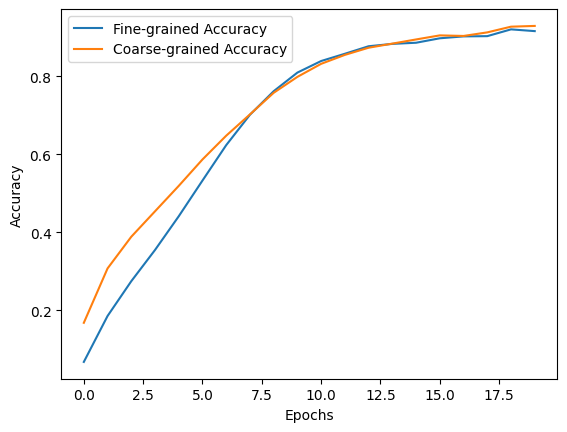

In [109]:
# Plot accuracy vs. epochs for gamma=0.5
plt.plot(range(len(history.history['fine_output_accuracy'])), history.history['fine_output_accuracy'], label='Fine-grained Accuracy')
plt.plot(range(len(history.history['coarse_output_accuracy'])), history.history['coarse_output_accuracy'], label='Coarse-grained Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [110]:
# Test the model on a random test image
random_ind = np.random.randint(0, x_test.shape[0])
image = x_test[random_ind]
expected_fine_label = y_test_fine[random_ind]
expected_coarse_label = y_test_coarse[random_ind]

# Make predictions
image = np.expand_dims(image, axis=0)
fine_pred, coarse_pred = model.predict(image)

print('Expected Fine Label:', np.argmax(expected_fine_label))
print('Predicted Fine Label:', np.argmax(fine_pred))
print('Expected Coarse Label:', np.argmax(expected_coarse_label))
print('Predicted Coarse Label:', np.argmax(coarse_pred))

1/1 [==============================] - 0s 144ms/step
Expected Fine Label: 38
Predicted Fine Label: 34
Expected Coarse Label: 11
Predicted Coarse Label: 12


In [111]:
# Evaluate the model on the test data
test_loss = model.evaluate(x_test, {'fine_output': y_test_fine, 'coarse_output': y_test_coarse}, verbose=0)
test_acc_fine = test_loss[3]  # Fine-grained accuracy
test_acc_coarse = test_loss[4]  # Coarse-grained accuracy

print(f'Test Fine-grained Accuracy: {test_acc_fine * 100:.2f}%')
print(f'Test Coarse-grained Accuracy: {test_acc_coarse * 100:.2f}%')


Test Fine-grained Accuracy: 26.79%
Test Coarse-grained Accuracy: 38.64%


**Enhanced Multi-Task Learning with ResNet50**

In [112]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Create your model on top of the pre-trained ResNet50
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Fine-grained classification branch
fine_output = tf.keras.layers.Dense(100, activation='softmax', name='fine_output')(x)

# Coarse-grained classification branch
coarse_output = tf.keras.layers.Dense(20, activation='softmax', name='coarse_output')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=[fine_output, coarse_output])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss={'fine_output': 'categorical_crossentropy', 'coarse_output': 'categorical_crossentropy'},
              loss_weights={'fine_output': 0.5, 'coarse_output': 0.5},
              metrics=['accuracy'])

# Fine-tune the model on your dataset
history = model.fit(x_train, {'fine_output': y_train_fine, 'coarse_output': y_train_coarse},
                    epochs=15, batch_size=128, validation_data=(x_test, {'fine_output': y_test_fine, 'coarse_output': y_test_coarse}))

# Evaluate the model on the test data
test_loss = model.evaluate(x_test, {'fine_output': y_test_fine, 'coarse_output': y_test_coarse}, verbose=0)

test_acc_fine = test_loss[3]  # Fine-grained accuracy
test_acc_coarse = test_loss[4]  # Coarse-grained accuracy

print(f'Test Fine-grained Accuracy: {test_acc_fine * 100:.2f}%')
print(f'Test Coarse-grained Accuracy: {test_acc_coarse * 100:.2f}%')


Epoch 1/15
391/391 [==============================] - 59s 71ms/step - loss: 2.5160 - fine_output_loss: 3.1283 - coarse_output_loss: 1.9038 - fine_output_accuracy: 0.2464 - coarse_output_accuracy: 0.4231 - val_loss: 4.3368 - val_fine_output_loss: 5.0737 - val_coarse_output_loss: 3.5998 - val_fine_output_accuracy: 0.0927 - val_coarse_output_accuracy: 0.1969
Epoch 2/15
391/391 [==============================] - 25s 65ms/step - loss: 1.9577 - fine_output_loss: 2.4340 - coarse_output_loss: 1.4815 - fine_output_accuracy: 0.3661 - coarse_output_accuracy: 0.5346 - val_loss: 2.2478 - val_fine_output_loss: 2.7742 - val_coarse_output_loss: 1.7214 - val_fine_output_accuracy: 0.3233 - val_coarse_output_accuracy: 0.4901
Epoch 3/15
391/391 [==============================] - 26s 65ms/step - loss: 1.7937 - fine_output_loss: 2.2329 - coarse_output_loss: 1.3545 - fine_output_accuracy: 0.4054 - coarse_output_accuracy: 0.5721 - val_loss: 2.5258 - val_fine_output_loss: 3.0791 - val_coarse_output_loss: 1.972

**Further Adjustments to Improve the Accuracy**
1.   Individual Task heads now consists of multiple dense layers with ReLU activation functions
2.  Learning rate has been adjusted to 0.00001
3.  Giving Priority to Fine labels by adjusting the Loss_weights



In [115]:
from tensorflow.keras.applications import ResNet50
import tensorflow as tf

# Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Create your model on top of the pre-trained ResNet50
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)

# Fine-grained classification branch
fine_output = tf.keras.layers.Dense(64, activation='relu')(x)
fine_output = tf.keras.layers.Dense(32, activation='relu')(fine_output)
fine_output = tf.keras.layers.Dense(16, activation='relu')(fine_output)
fine_output = tf.keras.layers.Dense(8, activation='relu')(fine_output)
fine_output = tf.keras.layers.Dense(100, activation='softmax', name='fine_output')(fine_output)

# Coarse-grained classification branch
coarse_output = tf.keras.layers.Dense(32, activation='relu')(x)
coarse_output = tf.keras.layers.Dense(16, activation='relu')(coarse_output)
coarse_output = tf.keras.layers.Dense(20, activation='softmax', name='coarse_output')(coarse_output)

# Combine both branches in the model
model = tf.keras.Model(inputs=base_model.input, outputs=[fine_output, coarse_output])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.00001),  # Adjust the learning rate as needed
              loss={'fine_output': 'categorical_crossentropy', 'coarse_output': 'categorical_crossentropy'},
              loss_weights={'fine_output': 0.7, 'coarse_output': 0.3},
              metrics=['accuracy'])

# Continue training the model for additional epochs
history = model.fit(x_train, {'fine_output': y_train_fine, 'coarse_output': y_train_coarse},
                    epochs=15, batch_size=128, validation_data=(x_test, {'fine_output': y_test_fine, 'coarse_output': y_test_coarse}))

# Evaluate the model on the test data
test_loss = model.evaluate(x_test, {'fine_output': y_test_fine, 'coarse_output': y_test_coarse}, verbose=0)

test_acc_fine = test_loss[3]  # Fine-grained accuracy
test_acc_coarse = test_loss[4]  # Coarse-grained accuracy

print(f'Test Fine-grained Accuracy: {test_acc_fine * 100:.2f}%')
print(f'Test Coarse-grained Accuracy: {test_acc_coarse * 100:.2f}%')


Epoch 1/15
391/391 [==============================] - 59s 76ms/step - loss: 3.5192 - fine_output_loss: 4.0519 - coarse_output_loss: 2.2763 - fine_output_accuracy: 0.0834 - coarse_output_accuracy: 0.3129 - val_loss: 8.2799 - val_fine_output_loss: 8.9815 - val_coarse_output_loss: 6.6428 - val_fine_output_accuracy: 0.0457 - val_coarse_output_accuracy: 0.1740
Epoch 2/15
391/391 [==============================] - 28s 72ms/step - loss: 2.7966 - fine_output_loss: 3.2262 - coarse_output_loss: 1.7941 - fine_output_accuracy: 0.1891 - coarse_output_accuracy: 0.4456 - val_loss: 3.9408 - val_fine_output_loss: 4.4779 - val_coarse_output_loss: 2.6874 - val_fine_output_accuracy: 0.1526 - val_coarse_output_accuracy: 0.3211
Epoch 3/15
391/391 [==============================] - 26s 67ms/step - loss: 2.3974 - fine_output_loss: 2.7768 - coarse_output_loss: 1.5120 - fine_output_accuracy: 0.2748 - coarse_output_accuracy: 0.5284 - val_loss: 3.2011 - val_fine_output_loss: 3.6530 - val_coarse_output_loss: 2.146